# Midterm

## File Locations

In [1]:
ATHLETES = './data/athletes.csv'
MOVIES = './data/movies.csv'

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Function Declarations

In [3]:
sns.set()
DPI = 200

def plot_large():
    plt.figure(figsize=(8, 5), dpi=DPI)

## Part Two

In [4]:
athletes_df = pd.read_csv(ATHLETES)
athletes_df.head()

,Name,Country,Age,"Height, cm",Weight,Sex,Date of birth,Place of birth,Gold,Silver,Bronze,Total,Sport,Event
0,Lamusi A,People's Republic of China,23,170.0,60.0,M,6/2/1989,NEIMONGGOL (CHN),0,0,0,0,Judo,Men's -60kg
1,A G Kruger,United States of America,33,193.0,125.0,M,2/18/1979,Sheldon (USA),0,0,0,0,Athletics,Men's Hammer Throw
2,Jamale Aarrass,France,30,187.0,76.0,M,11/15/1981,BEZONS (FRA),0,0,0,0,Athletics,Men's 1500m
3,Abdelhak Aatakni,Morocco,24,NaN,NaN,M,2/9/1988,AIN SEBAA (MAR),0,0,0,0,Boxing,Men's Light Welter (64kg)
4,Maria Abakumova,Russian Federation,26,178.0,85.0,F,1/15/1986,STAVROPOL REGION (RUS),0,0,0,0,Athletics,Women's Javelin Throw


### Problem 1: Cleaning the data
We first want to find out how many missing values are there. The following queries will tell us.

In [5]:
df = athletes_df[athletes_df.isna().any(axis=1)]
missing_percent = len(df) * 100 / len(athletes_df)
print("Total number of rows: {}".format(len(athletes_df)))
print("Percentage of missing data: {}%".format(missing_percent))

Total number of rows: 10384
Percentage of missing data: 37.384437596302%


More than a third of the data has missing values in at least one column. We cannot simply remove all the rows which have missing values, because we may be throwing out rows where the data is missing in columns that we're not interested in. Instead, as we know what columns we're interested in, we can only remove rows with data missing in the columns we're interested in:
* Height, cm
* Weight
* Sex
* Total
* Sport
* Country

Now we check how many rows have missing data in only these columns.

In [6]:
columns = ['Height, cm', 'Weight', 'Sex', 'Total', 'Sport', 'Country']
athletes_clean_df = athletes_df.dropna(subset=columns)
missing_percent = (len(athletes_df) - len(athletes_clean_df)) * 100 / len(athletes_df)
print("Total number of rows: {}".format(len(athletes_df)))
print("Percentage of missing data: {}%".format(missing_percent))

Total number of rows: 10384
Percentage of missing data: 12.962249614791988%


Instead of over a third of the data being dropped, we're only dropping a little over 12% of the data. Though still a significant amount of data, it's a lot less data that we'll be dropping than before.

We'll therefore be working with `athletes_clean_df` for the rest of **Part Two**.

### Problem 2: Scatter Plot of athletes' weight vs height

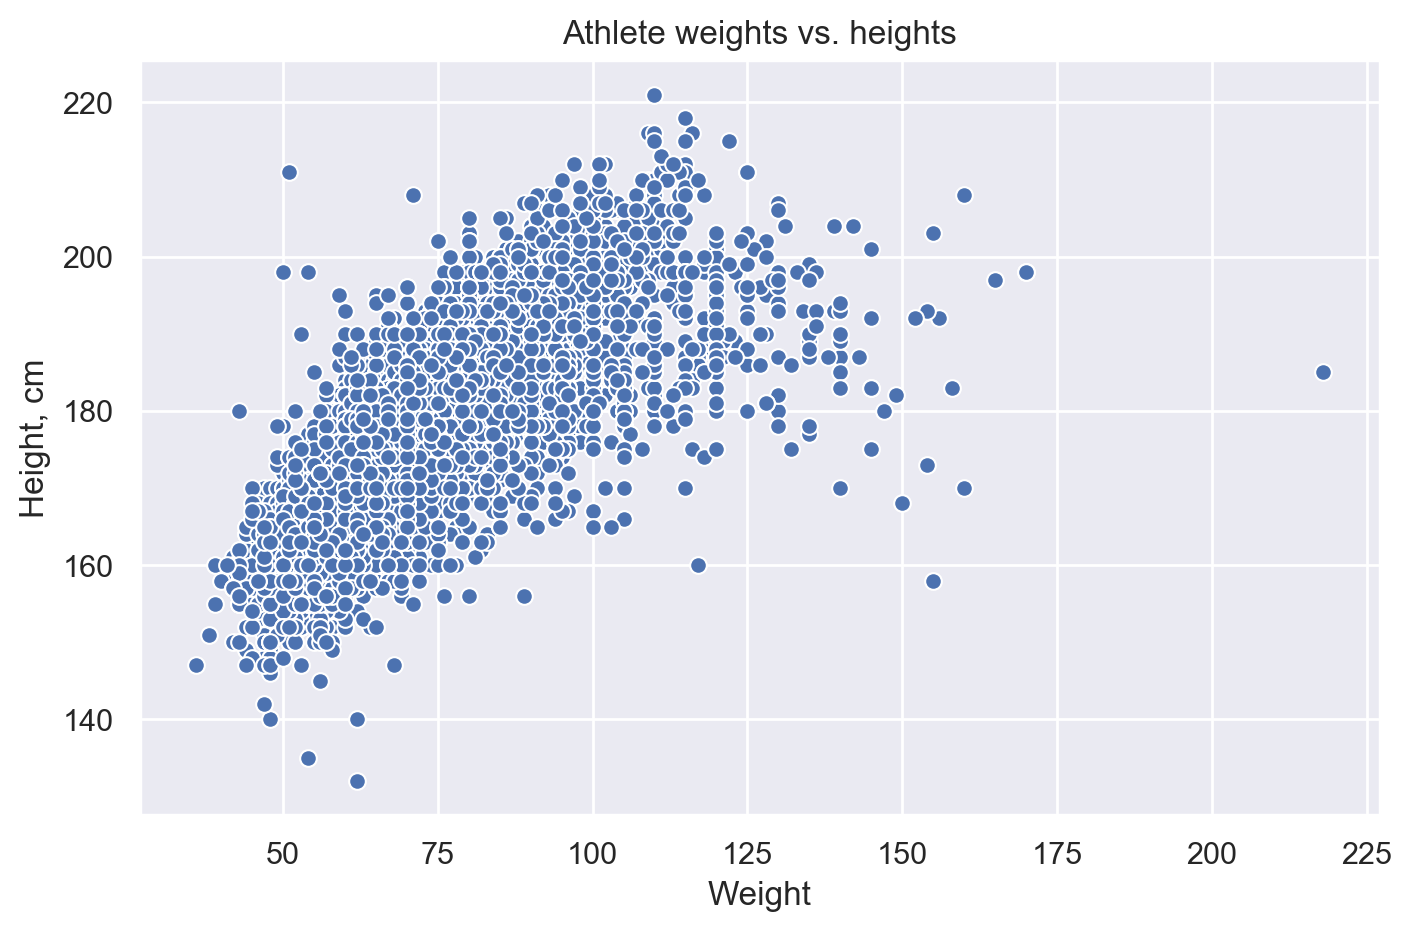

In [7]:
plot_large()
sns.scatterplot(x='Weight', y='Height, cm', data=athletes_clean_df)
plt.title('Athlete weights vs. heights');

### Problem 3: Box Plots
In the following code we use the `pandas.DataFrame.assign()` method to add a new column to the datafr

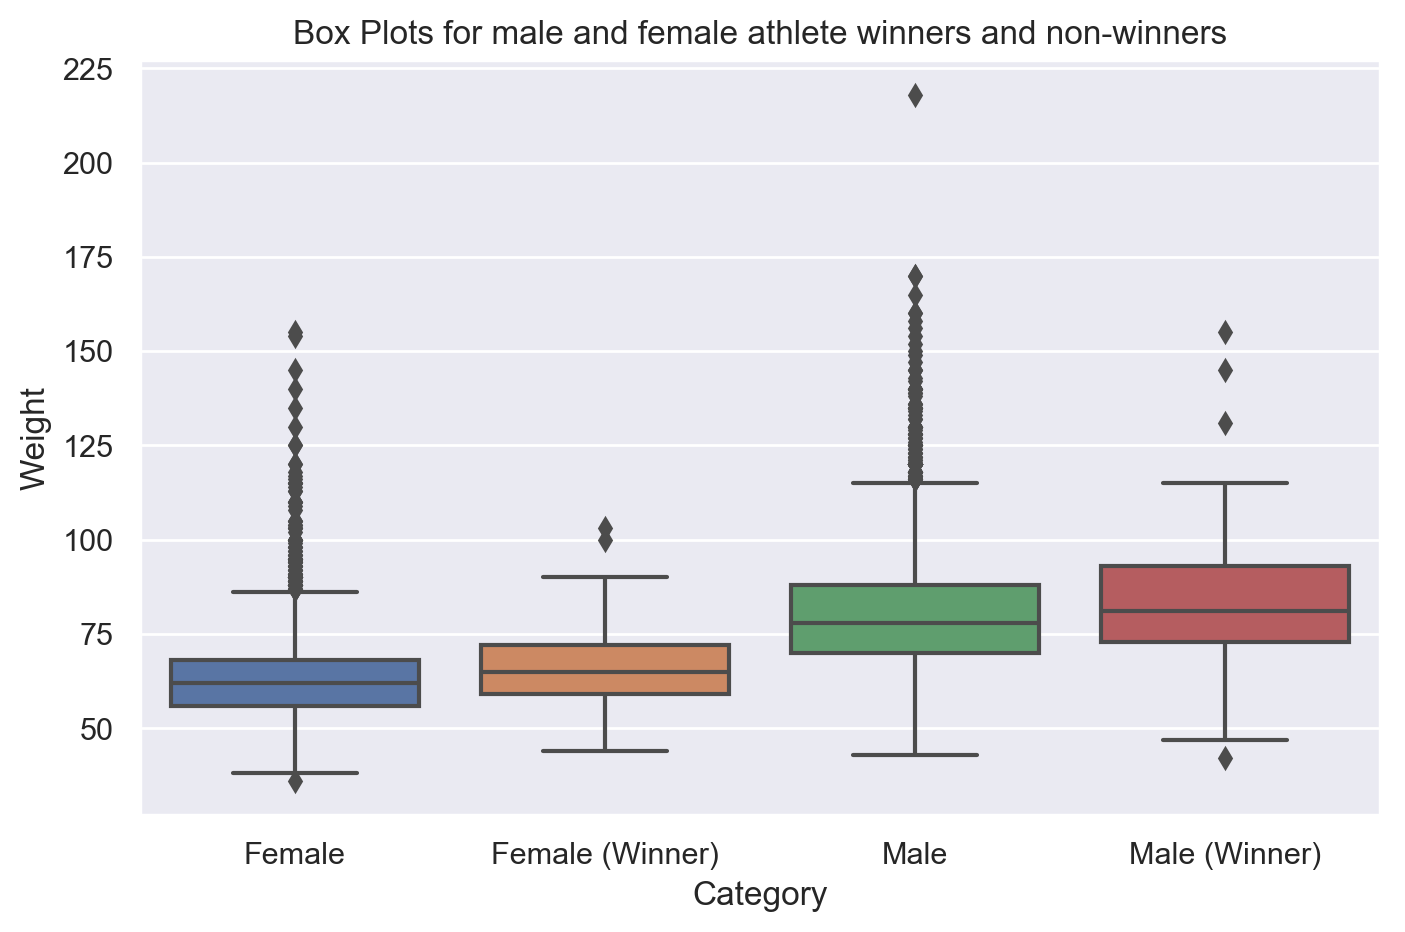

In [8]:
plot_large()

athletes_clean_df = athletes_clean_df.assign(Category=0)

athletes_clean_df.loc[(athletes_clean_df.Sex == 'M') & (athletes_clean_df.Total == 0), 'Category'] = 'Male'
athletes_clean_df.loc[(athletes_clean_df.Sex == 'M') & (athletes_clean_df.Total > 0), 'Category'] = 'Male (Winner)'
athletes_clean_df.loc[(athletes_clean_df.Sex == 'F') & (athletes_clean_df.Total == 0), 'Category'] = 'Female'
athletes_clean_df.loc[(athletes_clean_df.Sex == 'F') & (athletes_clean_df.Total > 0), 'Category'] = 'Female (Winner)'

sns.boxplot(x='Category', y='Weight', data=athletes_clean_df.sort_values(by=['Category']))
plt.title('Box Plots for male and female athlete winners and non-winners');

#### Comments
* In both categories, the winners' weight range is slightly higher than the non-winners' weight range.
* We can see in general that there are a lot of outliers for non-winners in male & female categories, but a lot less in winners. This gives a very good indication that there is an ideal weight range that you would want to be in.
* Female athletes have a lower weight range than male athletes.

### Problem 4: Swarm Plots of athlete ages and weights

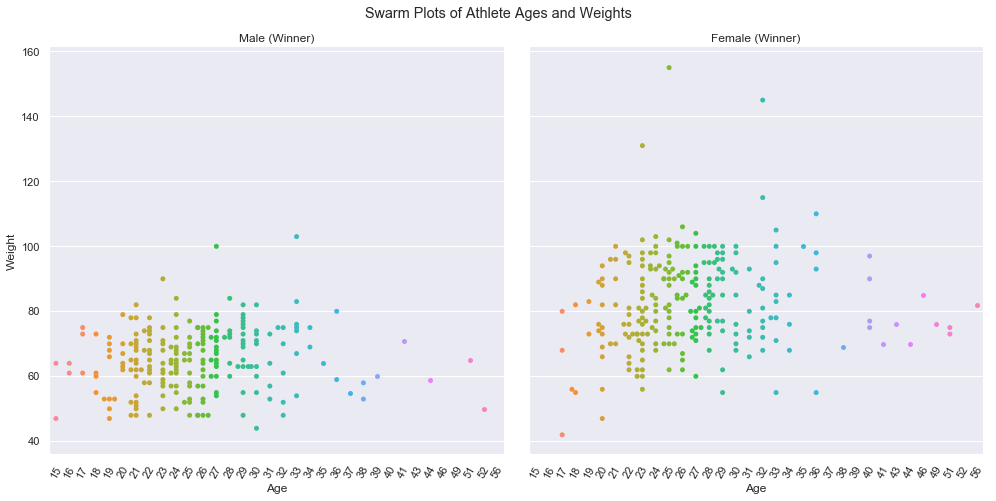

In [9]:
g = sns.catplot(x='Age', y='Weight', col='Category',
                data=athletes_clean_df[(athletes_clean_df.Category == 'Male (Winner)')
                                       | (athletes_clean_df.Category == 'Female (Winner)')],
                height=7, aspect=1, kind='swarm')
g.set_xticklabels(rotation=60)
axes = g.axes.flatten()
axes[0].set_title("Male (Winner)")
axes[1].set_title("Female (Winner)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Swarm Plots of Athlete Ages and Weights');

#### Comments
Female winners tend to have a higher weight than male winners, across all ages.

### Problem 5: Violin Plots for Archery, Sailing, and Swimming

Text(0.5, 1.0, 'Age Distribution per Sport')

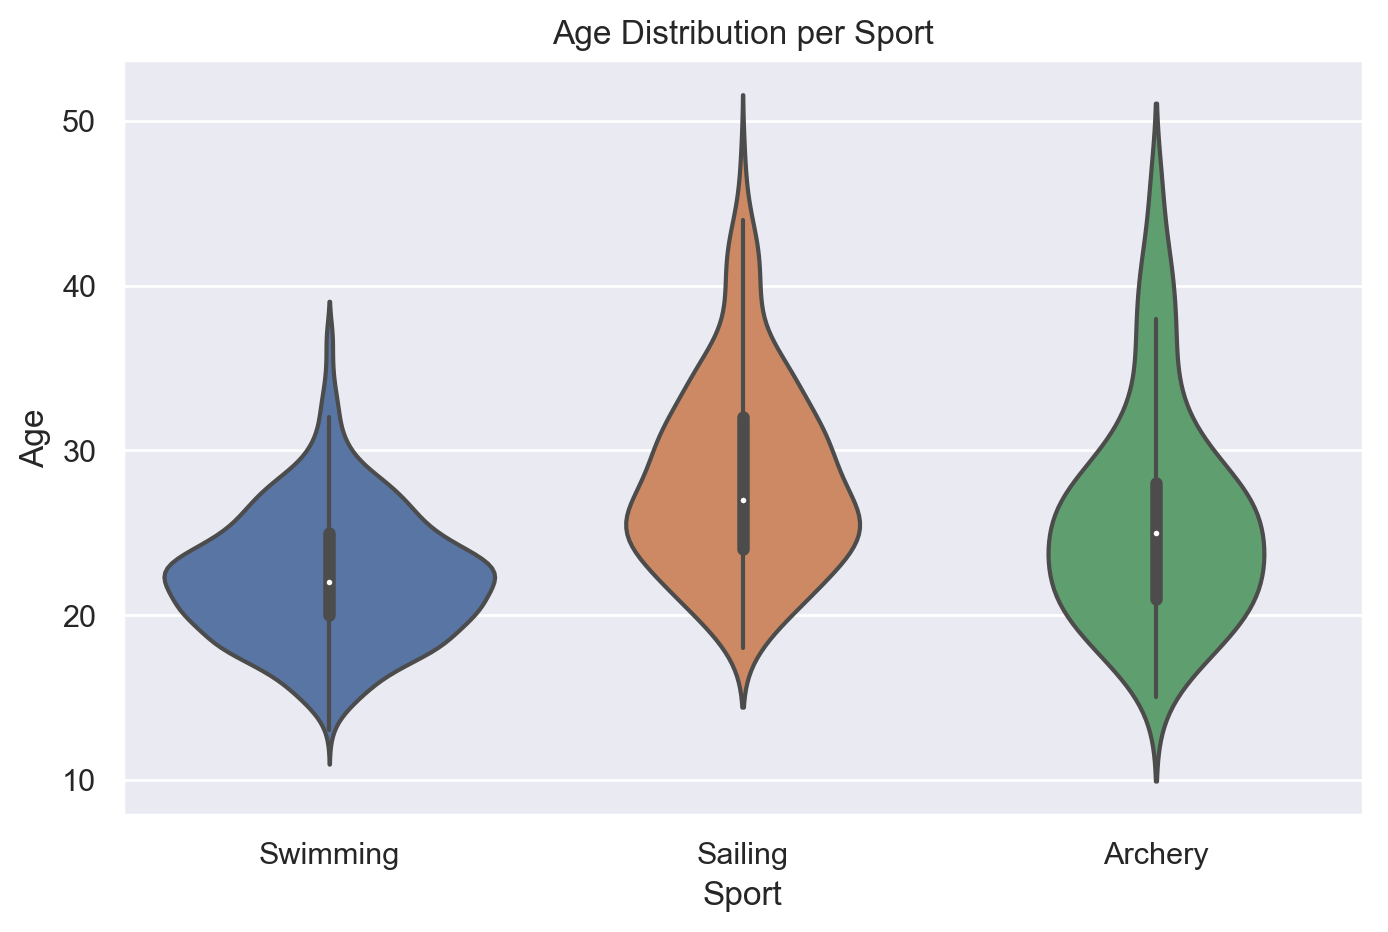

In [10]:
sports = ['Archery', 'Sailing', 'Swimming']
plot_large()
sns.violinplot(x='Sport', y='Age', data=athletes_clean_df[athletes_clean_df.Sport.isin(sports)])
plt.title('Age Distribution per Sport')

#### Comments
* Archery has the widest range of ages, Swimming has the shortest range and Sailing's age range falls between the two.
* The average Swimming age is the youngest, followed closely by Archery and then by Sailing.
* The tapering edges at the top of each plot shows older athletes; Swimming has the least number of old athletes, Sailing has a moderate amount and Archery has the most out of the 3 sports.

### Problem 6: Histogram of Medals per Country
We need to format the data in order to plot it:
1. Group the data by countries, taking the total of all its rows and arranging them in descending order of total medals
1. Drop the countries which have no medals, otherwise we have too many countries to plot which are adding no data to the graph
1. Remove unneeded columns
1. Plot the histogram

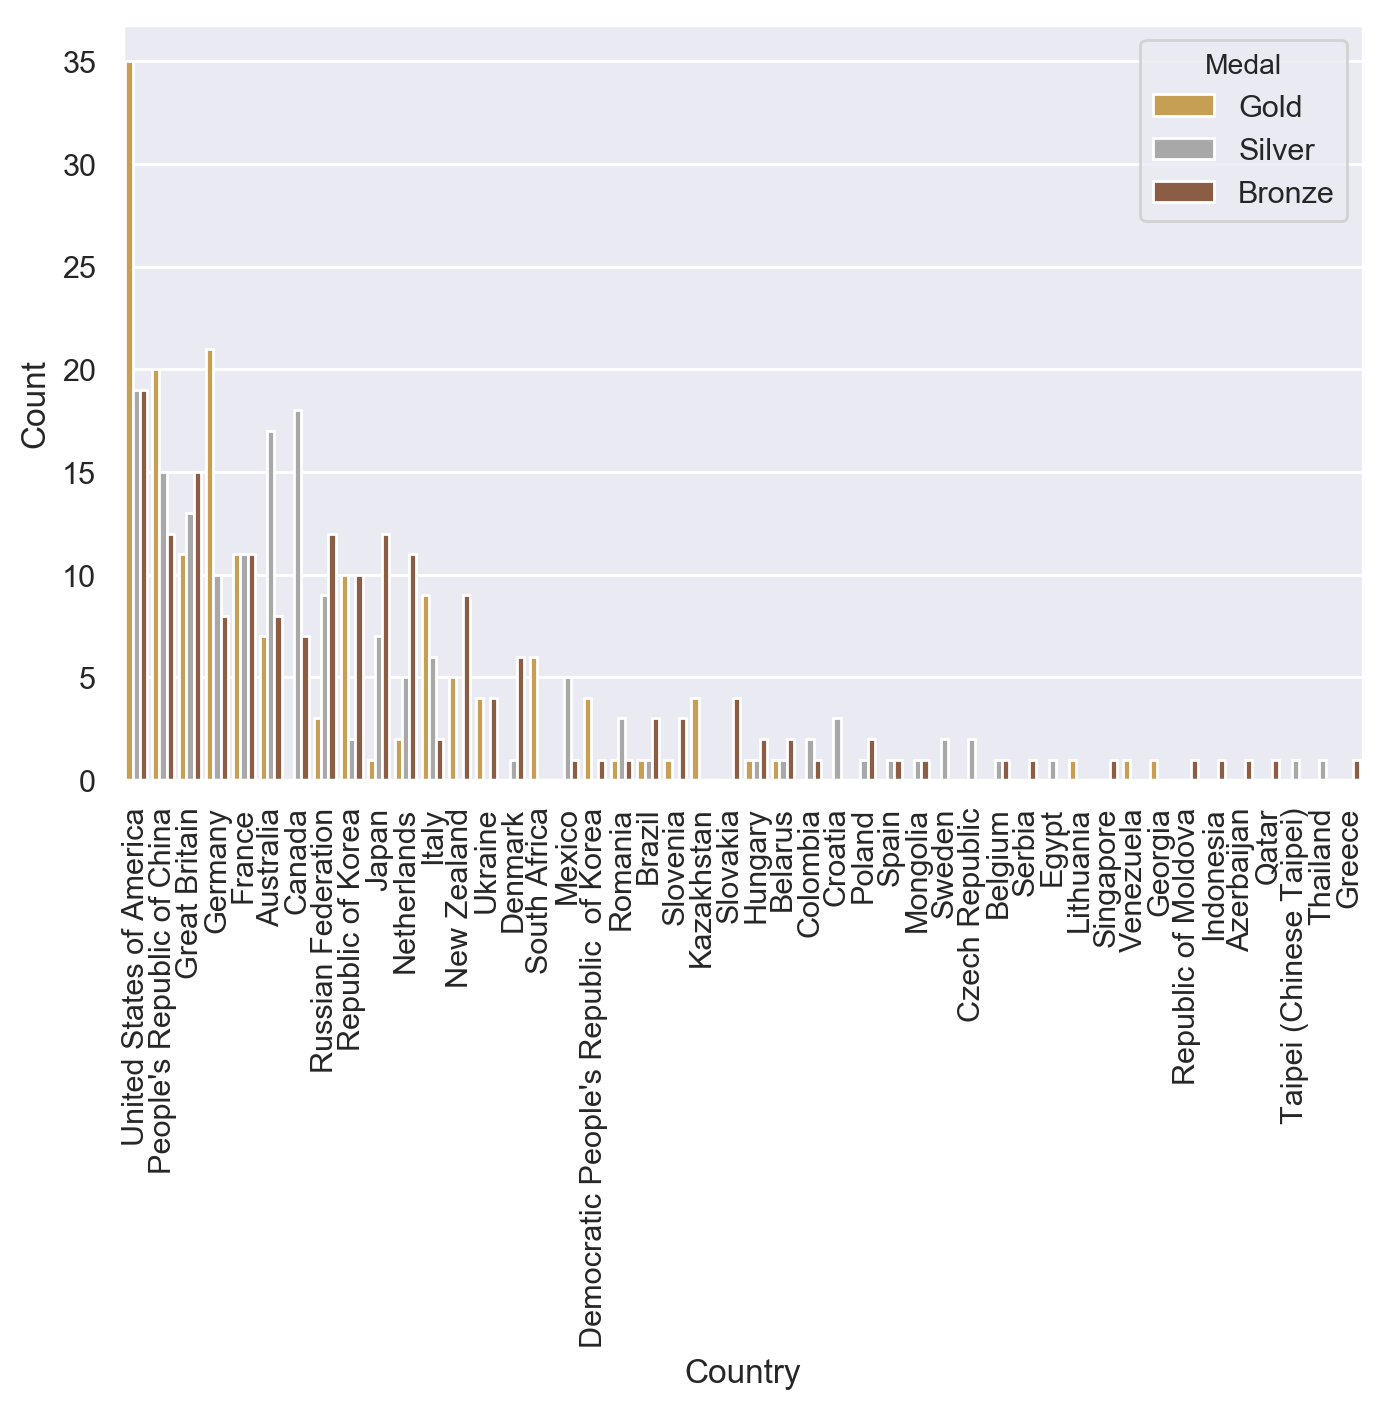

In [11]:
# 1
grouped_df = athletes_clean_df.groupby(['Country']).sum().reset_index().sort_values(by=['Total'], ascending=False)
# 2
grouped_df = grouped_df[grouped_df.Total > 0]
# 3
columns_to_keep = ['Country', 'Gold', 'Silver', 'Bronze']
grouped_df = pd.melt(grouped_df[columns_to_keep], id_vars="Country", var_name="Medal", value_name="Count")
# 4
plot_large()
medal_palette = ['#D9A441', '#A8A8A8', '#965A38']
sns.barplot(x='Country', y='Count', hue='Medal', data=grouped_df, palette=medal_palette)
plt.xticks(rotation=90);